In [2]:
import copy
import torchvision.models as models
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from sklearn.utils import resample
import os
import numpy as np
import matplotlib.pyplot as plt

# simple dataset

In [77]:
### preparing Data
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'your device is {device}')

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.255])

batch_size = 32

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        # transforms.Grayscale(),
        transforms.RandomResizedCrop((224, 224)),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        # transforms.Grayscale(),
        transforms.RandomResizedCrop((224, 224)),
        transforms.Normalize(mean, std)
    ])
}

data_path = 'D:\Master Project\model\model-1\data'
datasets = {x: ImageFolder(root=os.path.join(data_path, x), transform=data_transforms[x]) for x in ['train', 'val']}
print('datasets have been created')

dataloaders = {x: DataLoader(dataset=datasets[x], batch_size=batch_size, num_workers=2, shuffle=False, drop_last=True)
               for x in ['train', 'val']}
print('dataloaders have been created')

class_names = datasets['train'].classes
print(f'there are {len(class_names)} classes, and class names are {class_names}')

class_counts = {x: len(datasets[x]) for x in ['train', 'val']}
print(f'Dataset sizes: {class_counts}')


from collections import Counter

class_counts = Counter()

for phase in ['train', 'val']:
    for _, label in dataloaders[phase]:
        class_counts.update(label.tolist())

# show details
for label, count in class_counts.items():
    print(f'Class {label}: {count} instances')



your device is cuda
datasets have been created
dataloaders have been created
there are 2 classes, and class names are ['myxo', 'non-myxo']
Dataset sizes: {'train': 445, 'val': 188}
Class 0: 191 instances
Class 1: 385 instances


# Augmented dataset

In [5]:
# Custom dataset class to handle oversampling
class BalancedImageFolder(ImageFolder):
    def __init__(self, root, transform=None, minority_class=0, augment_transforms=None):
        super().__init__(root, transform=transform)
        self.minority_class = minority_class
        self.augment_transforms = augment_transforms

        # Identify the minority and majority classes and their counts
        class_counts = self._get_class_counts()
        self.max_count = max(class_counts.values())
        self.indices = self._oversample_indices(class_counts)

    def _get_class_counts(self):
        class_counts = {}
        for _, label in self.samples:
            class_counts[label] = class_counts.get(label, 0) + 1
        return class_counts

    def _oversample_indices(self, class_counts):
        # Oversample minority indices
        minority_indices = [i for i, (_, label) in enumerate(self.samples) if label == self.minority_class]
        required_samples = self.max_count - class_counts[self.minority_class]
        oversampled_minority_indices = resample(minority_indices, replace=True, n_samples=required_samples, random_state=123)
        return list(range(len(self.samples))) + oversampled_minority_indices

    def __getitem__(self, index):
        actual_index = self.indices[index]
        path, target = self.samples[actual_index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if target == self.minority_class and self.augment_transforms is not None:
            sample = self.augment_transforms(sample)
        return sample, target

    def __len__(self):
        return len(self.indices)

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'your device is {device}')

# # Data normalization mean and std
# mean = np.array([0.485, 0.456, 0.406])
# std = np.array([0.229, 0.224, 0.255])

# Batch size
batch_size = 32

# Additional augmentations for the minority class
minority_augment_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
])

# Standard data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomResizedCrop(1040),
        # transforms.Normalize(mean, std),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        # transforms.Resize(256),
        transforms.CenterCrop(1040),
        # transforms.Normalize(mean, std),
    ]),
}

# Path to your data
data_path = 'D:\\Master Project\\model\\model-1\\data'

# Creating datasets with BalancedImageFolder
datasets = {
    x: BalancedImageFolder(
        root=os.path.join(data_path, x),
        transform=data_transforms[x],
        minority_class=0,  
        augment_transforms=minority_augment_transforms if x == 'train' else None,
    ) for x in ['train', 'val']
}
print('Datasets have been created.')

# Creating dataloaders
dataloaders = {
    x: DataLoader(dataset=datasets[x], batch_size=batch_size, num_workers=0, shuffle=True if x == 'train' else False, drop_last=True)
    for x in ['train', 'val']
}
print('Dataloaders have been created.')

# Get class names
class_names = datasets['train'].classes
print(f'There are {len(class_names)} classes, and class names are {class_names}')

# Count class instances
class_counts = {x: len(datasets[x]) for x in ['train', 'val']}
print(f'Dataset sizes: {class_counts}')

from collections import Counter

class_counts = Counter()

for phase in ['train', 'val']:
    for images, labels in dataloaders[phase]:
        # Ensure labels are moved to CPU and converted to list if necessary
        labels_list = labels.cpu().numpy().tolist() if device == 'cuda' else labels.tolist()
        class_counts.update(labels_list)

# Show details
for label, count in class_counts.items():
    print(f'Class {label}: {count} instances')



your device is cuda
Datasets have been created.
Dataloaders have been created.
There are 2 classes, and class names are ['myxo', 'non-myxo']
Dataset sizes: {'train': 620, 'val': 264}


C:\Users\Mahdiar\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Class 1: 436 instances
Class 0: 428 instances


## simple cnn model

In [21]:
from torchsummary import summary


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(512 * 33 * 33, 2)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))
        x = nn.functional.relu(self.conv5(x))
        x = x.view(-1, 512 * 33 * 33)
        x = nn.functional.relu(self.fc1(x))
        return x
    



model = SimpleCNN()
input_size = (3, 1040, 1040)
model = model.to(device)
summary(model, input_size)
print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 520, 520]             896
            Conv2d-2         [-1, 64, 260, 260]          18,496
            Conv2d-3        [-1, 128, 130, 130]          73,856
            Conv2d-4          [-1, 256, 65, 65]         295,168
            Conv2d-5          [-1, 512, 33, 33]       1,180,160
            Linear-6                    [-1, 2]       1,115,138
Total params: 2,683,714
Trainable params: 2,683,714
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 12.38
Forward/backward pass size (MB): 128.03
Params size (MB): 10.24
Estimated Total Size (MB): 150.65
----------------------------------------------------------------
SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 

## pretrained model: efficientnet_v2_s

In [13]:
model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False

last_layer = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
)

model.classifier = last_layer
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=2, bias=True)
)

In [22]:
from datetime import datetime
from easydict import EasyDict


# train function 
def train_model(model, criterion, optimizer, dataloaders, datasets, epoch_num=25):
    acc_list = EasyDict({'train': [], 'val': []})
    loss_list = EasyDict({'train': [], 'val': []})

    # Copy the best model weights for loading at the End
    best_model_wts = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0

    # Iterating over epochs
    for epoch in range(1, epoch_num + 1):
        print(f'Epoch {epoch}/{epoch_num}:')

        # Each epoch has two phase Train and Validation
        for phase in ['train', 'val']:
            s0 = datetime.now()
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # For calculating Loss and Accuracy at the end of epoch
            running_loss = 0.0
            running_corrects = 0.0

            # Iterating over batches and data for training and validation
            for idx, batch in enumerate(dataloaders[phase], 0):
                inputs, labels = batch

                # Transfer data and labels to CUDA if is available
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward Pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, predictions = torch.max(outputs, 1)

                    # Back Propagation and updating weights
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            # Calculating Accuracy and Loss per phase
            epoch_loss = running_loss / len(datasets[phase])
            epoch_accuracy = running_corrects.double() / len(datasets[phase])

            # Show epoch details
            delta = datetime.now() - s0
            print(f'{phase.capitalize()} Accuracy: {epoch_accuracy:.4f} | Loss: {epoch_loss:.4f} | time: {delta}')

            # Copy the model weights if its better
            if phase == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_wts = copy.deepcopy(model.state_dict())
                print('Best model weights updated!')

            # Save Loss and accuracy
            acc_list[phase].append(epoch_accuracy)
            loss_list[phase].append(epoch_loss)
        print()

    print(f'Best Accuracy: {best_accuracy:.4f}')

    # Loading best model weights 
    model.load_state_dict(best_model_wts)
    return model, acc_list, loss_list

In [23]:
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
model = model.to(device)
# train model
model, acc_lists, loss_lists = train_model(model, criterion, optimizer, dataloaders, datasets, epoch_num=10)

Epoch 1/10:
Train Accuracy: 0.4952 | Loss: 0.8474 | time: 0:01:20.611014
Val Accuracy: 0.4697 | Loss: 0.6721 | time: 0:00:10.144812
Best model weights updated!

Epoch 2/10:
Train Accuracy: 0.4903 | Loss: 0.6797 | time: 0:01:23.673067
Val Accuracy: 0.4697 | Loss: 0.6721 | time: 0:00:07.289292

Epoch 3/10:
Train Accuracy: 0.4903 | Loss: 0.6797 | time: 0:01:15.838918
Val Accuracy: 0.4697 | Loss: 0.6721 | time: 0:00:09.831801

Epoch 4/10:
Train Accuracy: 0.4887 | Loss: 0.6797 | time: 0:01:19.322387
Val Accuracy: 0.4697 | Loss: 0.6721 | time: 0:00:09.781594

Epoch 5/10:
Train Accuracy: 0.4903 | Loss: 0.6797 | time: 0:01:34.892296
Val Accuracy: 0.4697 | Loss: 0.6721 | time: 0:00:10.533280

Epoch 6/10:
Train Accuracy: 0.4935 | Loss: 0.6797 | time: 0:01:29.953821
Val Accuracy: 0.4697 | Loss: 0.6721 | time: 0:00:09.800700

Epoch 7/10:
Train Accuracy: 0.4903 | Loss: 0.6797 | time: 0:01:23.792084
Val Accuracy: 0.4697 | Loss: 0.6721 | time: 0:00:09.424619

Epoch 8/10:
Train Accuracy: 0.4903 | Loss

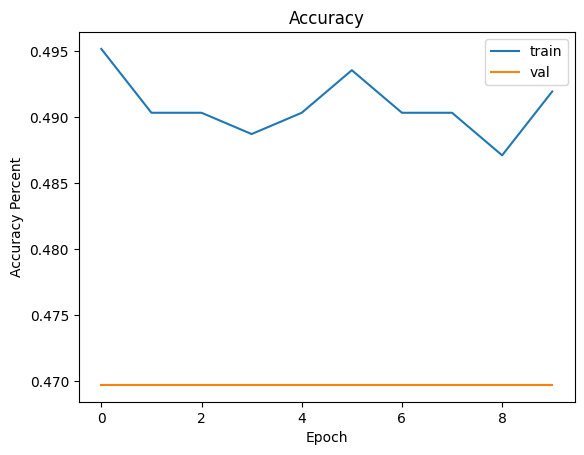

In [24]:
plt.plot([a.cpu() for a in acc_lists.train], label='train')
plt.plot([a.cpu() for a in acc_lists.val], label='val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Percent')
plt.legend()
plt.show()

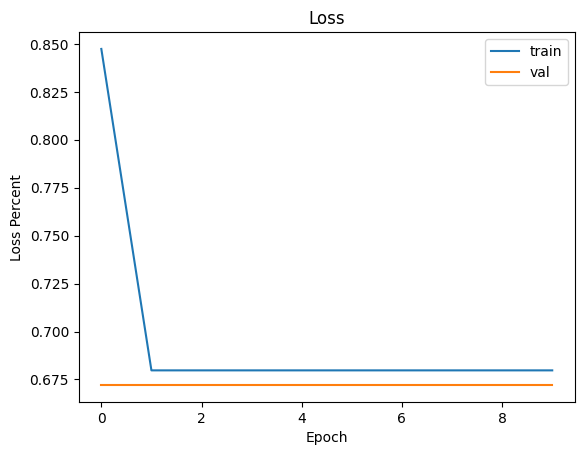

In [25]:
plt.plot([a for a in loss_lists.train], label='train')
plt.plot([a for a in loss_lists.val if a < 1], label='val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Percent')
plt.legend()
plt.show()

# Visualize model

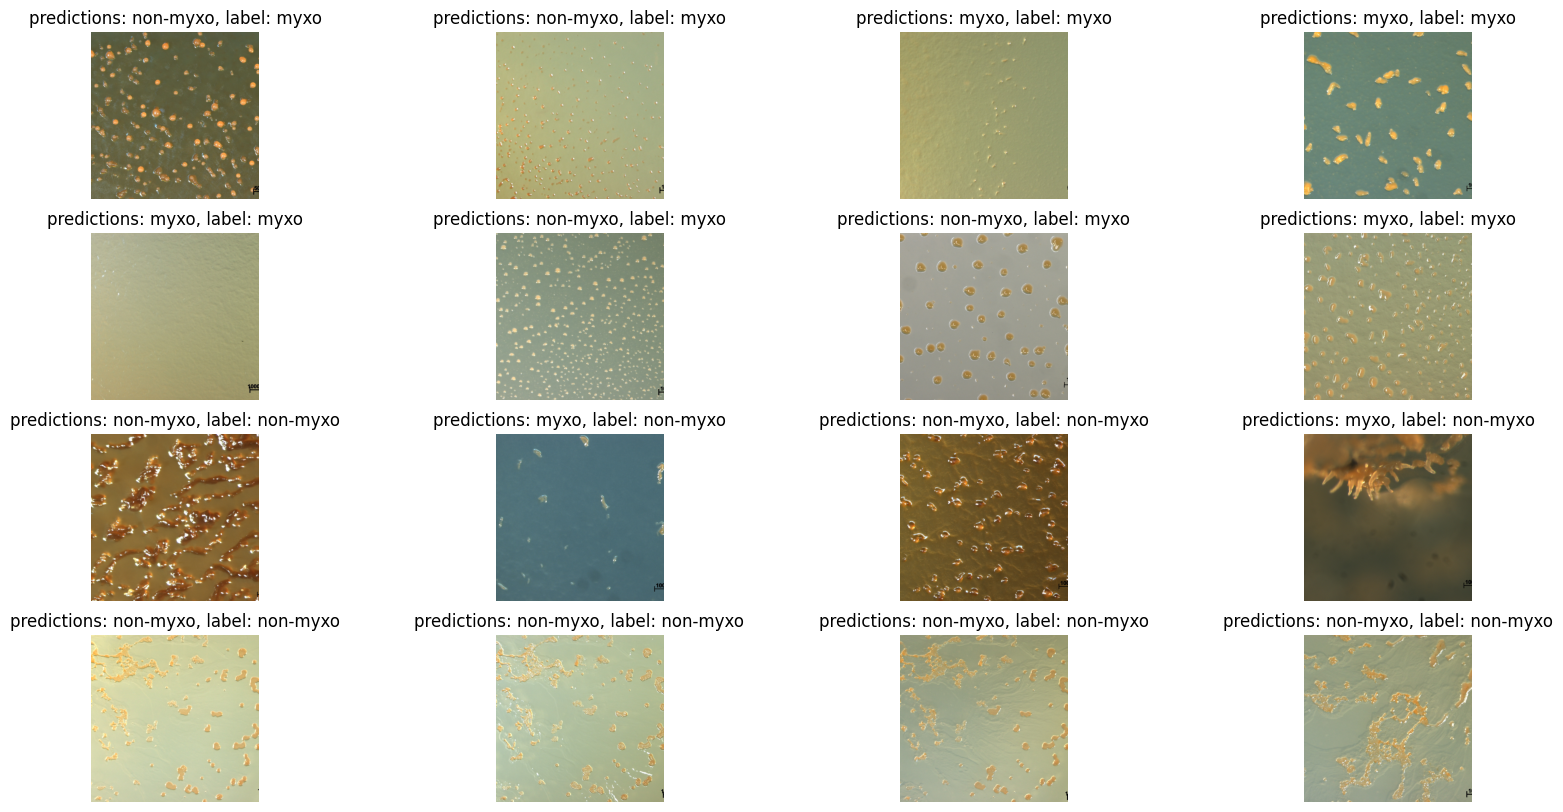

In [19]:
def visualize_model(model):
    model.eval()
    nrows, ncols = 4, 4
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                img = inputs.cpu().data[j]
                img = img.numpy().transpose((1, 2, 0))
                # img = std * img + mean
                img = np.clip(img, 0, 1)
                axes[i][j].axis('off')
                axes[i][j].set_title(
                    f'predictions: {class_names[predictions[j]]}, label: {class_names[labels[j]]}'
                )
                axes[i][j].imshow(img)
                if j == ncols - 1:
                    break
            if i == nrows - 1:
                break


visualize_model(model)